# Generating Neighborhood Data

## Asbestos
The asbestos dataset doesn't contain readable neighborhood information, and my previous method of trying to reverse zipcodes to neighborhoods didn't work. I'll instead be using geopandas to determine the neigborhoods of data in 
our datasets

I used this as a reference for the capabilities of this setup:
https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6

In [1]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import shapely as shp
from shapely.geometry import Point, Polygon
import matplotlib as plt


ModuleNotFoundError: No module named 'geopy'

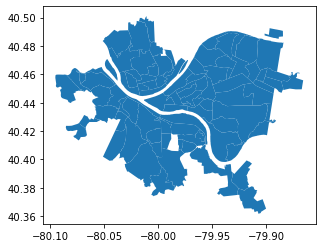

In [2]:
import shapely as shp
import matplotlib as plt
import geopandas as gpd

neighborhood_shapes = gpd.read_file("Neighborhoods_.geojson")
neighborhood_shapes.plot()

# Function which returns the neigborhood that a geographical location falls in
# This is used to combine the datasets
def getNeighborhood(latitude, longitude):
    point = shp.geometry.Point(longitude,latitude)
    # For each row in the shape data
    for _,x in neighborhood_shapes.iterrows():
        #Test if the point is within that neighborhood
        if(point.within(x["geometry"])):
            return x["hood"]
    
    return ""

In [ ]:
# import asbestos dataset
asbestos = pd.read_csv("Asbestos.csv")

#Filter to only pittsburgh
asbestos = asbestos[asbestos["city"]=="PITTSBURGH"]

# Create new array to store neighborhoods
neighborhoods = [] # new array

#Create array column of neighborhoods from the data
for _, row in asbestos.iterrows():
    neighborhoods.append(getNeighborhood(row["latitude"],row["longitude"]))

In [13]:
# Add new column of neighborhoods to dataframe
asbestos["neighborhood"] = neighborhoods

# Filter for only the rows with valid neighborhoods
asbestos = asbestos[asbestos["neighborhood"]!=""]

# Create new file
asbestos.to_csv("data_with_neighborhoods/Asbestos_WithNeighborhood.csv")

## Restauraunt Inspections

Now that asbestos is done, the next step is normalizing the resturauntInspection dataset.
I'll have to use geocoding to get lat/long coordinates from a street adress for this dataset.

I used this website as a reference for this section:
https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [14]:
#Import data
restaurants = pd.read_csv("restaurantInspections.csv")

# Filter for only Pittsburgh entries
restaurants = restaurants[restaurants["city"]=="Pittsburgh"]

# Construct adresses from data
restaurants_addresses = restaurants.apply(lambda row: "{} {}, {} {}".format(row["num"],row["street"],row["city"],row["state"]), axis=1)

# Add to original data, this will be used to get the lookup values
restaurants["address"] = restaurants_addresses

restaurants_addresses = restaurants_addresses.drop_duplicates()

print("Len:",len(restaurants_addresses.index))
print("Ratio:",len(restaurants_addresses.index)/len(restaurants.index))
print(restaurants_addresses)






Len: 6105
Ratio: 0.10910163160998623
14         3639 California Ave, Pittsburgh PA
27                 6 Marion St, Pittsburgh PA
40              5414 Walnut St, Pittsburgh PA
55            2123 Penn Avenue, Pittsburgh PA
80            1239 Itin Street, Pittsburgh PA
                         ...                 
88110    2400 Arlington Avenue, Pittsburgh PA
88111      3340 Liberty Avenue, Pittsburgh PA
88122       4560 Centre Avenue, Pittsburgh PA
88123       340 Freeport  Road, Pittsburgh PA
88126          902 Wood Street, Pittsburgh PA
Length: 6105, dtype: object


In [15]:

#Create new dictionary for neighborhoods
neighborhood_dict = {}

#Get locator
locator = Nominatim(user_agent="myGeocoder")

# set up progress bar
# This process takes a while because of rate limiting imposed by the api
progressBarSize = 50
progressBarIncrement = 1/progressBarSize
progress = 0

for x in range(progressBarSize):
    print("-", end = "")
print("")

index = 0

#For each address in the dataset, add the corresponding neighborhood to that row
print("This code block will take an extremely long time to run because of rate limits imposed by the geoencoding api."
          +"You do not need to run it again because the code saves the result as a csv you can import.")

response = input("\nWould you still like to run it? (Y/N) ")

if(response == "Y"):
    for row in restaurants_addresses:
        try:
            location = locator.geocode(row)
            neighborhoods.append(getNeighborhood(location.latitude,location.longitude))
            neighborhood_dict[row] = getNeighborhood(location.latitude,location.longitude)
        except:
            neighborhoods.append("")

        # Used to display the progress bar
        if(index/len(restaurants_addresses.index) > progress):
            print("=", end = "")
            progress+=progressBarIncrement
        index+=1

        print("")
        print("Done")

NameError: name 'Nominatim' is not defined

In [ ]:
# At this point, the neigborhoods_dict dictionary contains a lookup 
# for the neighborhoods of each adress in the data

#Create a new array for the neigborhoods
neighborhoods = []

for x in restaurants["address"]:
    # x should be in the dictionary, but just in case handle it
    if x in neighborhood_dict:
        neighborhoods.append(neighborhood_dict[x])
    else:
        neighborhoods.append("")

# Add new column of neighborhoods to dataframe
restaurants["neighborhood"] = neighborhoods

# Filter for only the rows with valid neighborhoods
restaurants_valid = restaurants[restaurants["neighborhood"]!=""]

# Create new file
restaurants_valid.to_csv("data_with_neighborhoods/restaurantInspections_WithNeighborhood.csv")

## Air Quality

The last dataset to deal with is air quality, which is a bit of a doozy because of how the data is collected. 
The data in this set is collected from a bunch of air monitoring sites located in various places in Alegheny county. There aren't one of these in every neighborhood though, so just taking the data from all the sites isn't an option. 

In [10]:
airQuality_Locations = pd.read_csv("airQuality_Locations.csv")
airQuality = pd.read_csv("airQuality.csv")

airQuality_UniqueLocations = airQuality.drop_duplicates("site")
airQuality_Average = airQuality[airQuality["stat"]=="Avg"][["site","datetime","so2"]]
#Display both the sites and number of times they were referenced
print(airQuality_Average.groupby("site").size())

FileNotFoundError: [Errno 2] File airQuality_Locations.csv does not exist: 'airQuality_Locations.csv'

---
Notice that for some reason, there are entries with a 2 appended to them, or the one case of (Near Road) being used as a site name. I have no idea why this is, but I have to normalize them. I can't find information as to what those modifiers mean, but I'm going to assume they reference the same sensor location as their base name. 

---

In [16]:
#locator for reverse geocoding
locator = Nominatim(user_agent="myGeocoder")

#New array to store neighborhoods
neighborhoods = []


# for _, row in airQuality_Locations.iterrows():
#     # This if statement tests for n/a values, it was more important for the asbestos dataset
#     if(row["latitude"]==row["latitude"] and row["longitude"] == row["longitude"]):
#         coordinates = geopy.point.Point(row["latitude"], row["longitude"])
#         location = locator.reverse(coordinates)
#         try:
#             neighborhoods.append(location.raw["address"]["neighbourhood"])
#         except:
#             neighborhoods.append("")
#             print(location.raw)
#             #print(row["s_name"] +": "+str(location.raw))
#         #neighborhoods.append(location.raw["neighbourhood"])
#     else:
#         neighborhoods.append("")

for _, row in airQuality_Locations.iterrows():
    neighborhoods.append(getNeighborhood(row["latitude"],row["longitude"]))

NameError: name 'Nominatim' is not defined

In [17]:
airQuality_Locations["neighborhood"] = neighborhoods

print(airQuality_Locations[["site","neighborhood"]])

NameError: name 'airQuality_Locations' is not defined

In [ ]:
geometry=[Point(xy) for xy in zip(airQuality_Locations["longitude"], airQuality_Locations["latitude"])]

crs={'init':'epsg:4326'}
geo = gpd.GeoDataFrame(airQuality_Locations,crs=crs,geometry=geometry)

fig = plt.pyplot.gcf()
fig.set_size_inches(50.5, 18.5,forward = True)

plot =  geo.append(neighborhood_shapes).plot()

for point, label in zip(geometry, airQuality_Locations["site"]):
    plot.annotate(label, xy=(point.x, point.y), xytext=(3, 3), textcoords="offset points")
    
